# Learning to Compare: Few Shot Learning

## 加载依赖库

In [1]:
import logging
%matplotlib inline
import matplotlib.pyplot as plt 
import math
import numpy as np
import os
import pandas as pd
import random
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
from sklearn.model_selection import train_test_split
from text_utils.utils.logger import init_log
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable
from torch.utils.data.sampler import Sampler
from torch.utils.data import DataLoader,Dataset

# 设置日志格式及等级
init_log(stream_level=logging.INFO)

## 设置超参数

In [2]:
# Omniglot数据集配置
OMNI_DATA_DIR = "./data/omniglot_resized/"
OMNI_MODEL_DIR = "./models_modify/omniglot/"
OMNI_TRAIN_NUM = 1200

# HWDB数据集配置
HWDB_DATA_DIR = "./data/hwdb_data/"
HWDB_MODEL_DIR = "./models_modify/hwdb/"
HWDB_TRAIN_NUM = 2800


# 图片大小参数
IMAGE_SIZE = 28
ENCODE_FEATURE_SIZE = 5

# Meta Learning参数
CLASS_NUM = 5
SUPPORT_NUM_PER_CLASS = 5
# omnig数据集中每类样本数为20
QUERY_NUM_PER_CLASS = 20 - SUPPORT_NUM_PER_CLASS

# 网络参数
FEATURE_DIM = 64
RELATION_DIM = 8
HIDDEN_UNIT = 10

# 训练参数
EPISODE = 150000
TEST_EPISODE = 1000
LEARNING_RATE = 1e-3
LR_STEP_SIZE = 100000
LR_STEP_GAMMA = 0.5
GPU = 1

# 训练信息展示参数
LOSS_PRINT_STEP = 100
EVAL_STEP = 5000

## 划分训练、测试类别

1. omnig数据集有1623种字符，每种字符有20张图片
2. hwdb数据集有3867种字符，每种字符有20张图片

In [3]:
def gen_char_folders(data_folder, train_num):
    # 加载所有文件夹名
    character_folders = list()
    for family in os.listdir(data_folder):
        if os.path.isdir(os.path.join(data_folder, family)):
            for character in os.listdir(os.path.join(data_folder, family)):
                if os.path.isdir(os.path.join(data_folder, family, character)):
                    character_folders.append(os.path.join(data_folder, family, character))
    n_folders = len(character_folders)
    logging.info("char folder number = {}".format(n_folders))

    # 划分训练集 测试集
    metatrain_folders, metatest_folders = train_test_split(character_folders, test_size=(n_folders-train_num), random_state=1)
    logging.info("metatrain_folders number = {}".format(len(metatrain_folders)))
    logging.info("metatest_folders number = {}".format(len(metatest_folders)))

    return metatrain_folders, metatest_folders

omni_metatrain_folders, omni_metaeval_folders = gen_char_folders(OMNI_DATA_DIR, OMNI_TRAIN_NUM)
hwdb_metatrain_folders, hwdb_metaeval_folders = gen_char_folders(HWDB_DATA_DIR, HWDB_TRAIN_NUM)

[2020-10-19 00:07:26,831][<ipython-input-3-0fe724192cd9>:gen_char_folders:10][INFO]:char folder number = 1623
[2020-10-19 00:07:26,834][<ipython-input-3-0fe724192cd9>:gen_char_folders:14][INFO]:metatrain_folders number = 1200
[2020-10-19 00:07:26,835][<ipython-input-3-0fe724192cd9>:gen_char_folders:15][INFO]:metatest_folders number = 423
[2020-10-19 00:07:26,868][<ipython-input-3-0fe724192cd9>:gen_char_folders:10][INFO]:char folder number = 3867
[2020-10-19 00:07:26,871][<ipython-input-3-0fe724192cd9>:gen_char_folders:14][INFO]:metatrain_folders number = 2800
[2020-10-19 00:07:26,872][<ipython-input-3-0fe724192cd9>:gen_char_folders:15][INFO]:metatest_folders number = 1067


## 观察训练、测试各类别的样本数量

In [4]:
folder_file_num = list()
for folder in (omni_metatrain_folders + omni_metaeval_folders):
    folder_file_num.append(len(os.listdir(folder)))

print("omniglot data:")
print(pd.DataFrame(folder_file_num).describe())


folder_file_num = list()
for folder in (hwdb_metatrain_folders + hwdb_metaeval_folders):
    folder_file_num.append(len(os.listdir(folder)))

print("hwdb data:")
print(pd.DataFrame(folder_file_num).describe())

omniglot data:
            0
count  1623.0
mean     20.0
std       0.0
min      20.0
25%      20.0
50%      20.0
75%      20.0
max      20.0
hwdb data:
            0
count  3867.0
mean     20.0
std       0.0
min      20.0
25%      20.0
50%      20.0
75%      20.0
max      20.0


## N-way K-shot 数据生成函数

生成的数据分为元训练集(support)、元测试集(query)

In [5]:
class CustomizedDataset(Dataset):
    """torch.DataLoader所需torch.Dataset类，重写__len__、__getitem__函数
    """
    def __init__(self, roots, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.roots = roots
        self.labels = labels

    def __len__(self):
        return len(self.roots)

    def __getitem__(self, idx):
        image_root = self.roots[idx]
        image = Image.open(image_root)
        image = image.convert('L')
        # per Chelsea's implementation
        image = image.resize((IMAGE_SIZE, IMAGE_SIZE), resample=Image.LANCZOS)
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[idx]
        if self.target_transform is not None:
            label = self.target_transform(label)
        return image, label


class Rotate(object):
    """图片预处理类：旋转
    """
    def __init__(self, angle):
        self.angle = angle
    def __call__(self, x, mode="reflect"):
        x = x.rotate(self.angle)
        return x


class ClassBalancedSampler(Sampler):
    """torch.DataLoader生成批处理数据时的抽样类
       从num_classes个类中，各抽样每个类的样本数为support_num_per_class个样本，每个类的样本数为total_num_per_class
    """

    def __init__(self, support_num_per_class, num_classes, total_num_per_class,shuffle=True):
        self.support_num_per_class = support_num_per_class
        self.num_classes = num_classes
        self.total_num_per_class = total_num_per_class
        self.shuffle = shuffle

    def __iter__(self):
        # return a single list of indices, assuming that items will be grouped by class
        batch = list()
        for j in range(self.num_classes):
            if self.shuffle:
                random_index = torch.randperm(self.total_num_per_class)[:self.support_num_per_class]
            else:
                random_index = range(self.total_num_per_class)[:self.support_num_per_class]
            logging.debug("random index: {}".format(random_index))
                
            cur_sample_list = list()
            for i in random_index:
                cur_sample_list.append(i + j * self.total_num_per_class)
            batch.extend(cur_sample_list)

        if self.shuffle:
            random.shuffle(batch)
        # 按类别遍历
        return iter(batch)

    def __len__(self):
        return 1


class DataLoaderGenerator(object):
    """生成support和query数据的DataLoader
    """
    def __init__(self, character_folders, num_classes, support_num, query_num):
        self.character_folders = character_folders
        self.num_classes = num_classes
        self.support_num = support_num
        self.query_num = query_num
    
    def sample_data(self):
        # 随机抽取num_classes个类别
        class_folders = random.sample(self.character_folders, self.num_classes)
        
        # 生成support和query集
        support_roots = []
        query_roots = []
        support_labels = []
        query_labels = []
        
        # 每类抽样指定数目的support、query数据
        for index, c in enumerate(class_folders):
            # 每个类别下的样本打乱
            temp = [os.path.join(c, x) for x in os.listdir(c)]
            # shuffle
            random.shuffle(temp)
            # 取self.support_num的样本到support_roots
            cur_support_sample = temp[: self.support_num]
            # 取self.query_num的样本到query_roots
            cur_query_sample = temp[self.support_num: self.support_num + self.query_num]
            support_roots += cur_support_sample
            query_roots += cur_query_sample
            # support_label和query_label按每次抽样的顺序依次给不一样的id就可以了
            support_labels += ([index] * len(cur_support_sample))
            query_labels += ([index] * len(cur_query_sample))
        logging.debug("support_roots number = {}".format(len(support_roots)))
        logging.debug("query_roots number = {}".format(len(query_roots)))
        return support_roots, support_labels, query_roots, query_labels
    
    def gen_data_loader(self):
        # 生成本次抽样得到的support数据（大小为：self.num_classes*self.support_num）
        #                query数据（大小为：self.num_classes*self.query_num）
        support_roots, support_labels, query_roots, query_labels = self.sample_data()
        
        # 随机本次图片的旋转角度
        degrees = random.choice([0,90,180,270])
        
        # 图片normalize的参数
        normalize = transforms.Normalize(mean=[0.92206], std=[0.08426])

        # 图片预处理的流程
        trans_func = transforms.Compose([
                Rotate(degrees),
                transforms.ToTensor(),
                normalize])

        # 构造support、query的torch.DataSet
        support_dataset = CustomizedDataset(support_roots, support_labels, transform=trans_func)
        query_dataset = CustomizedDataset(query_roots, query_labels, transform=trans_func)
        
        # 构造support、query的torch.DataLoader
        support_dataloader = DataLoader(support_dataset, batch_size=self.support_num*self.num_classes,
                                      sampler=ClassBalancedSampler(self.support_num,
                                                                   self.num_classes,
                                                                   self.support_num,
                                                                   shuffle=False))
        query_dataloader = DataLoader(query_dataset, batch_size=self.query_num*self.num_classes,
                                     sampler=ClassBalancedSampler(self.query_num,
                                                                  self.num_classes,
                                                                  self.query_num,
                                                                  shuffle=True))
        return support_dataloader, query_dataloader

### 展示生成的DataLoader中的数据

In [6]:
def display_multi_pics(pics_tensor, labels, col_num=5, title=None):
    """展示DataLoader抽样得到的样本
    """
    pic_number = pics_tensor.shape[0]
    row_num = math.ceil(pic_number/float(col_num))
    plt.figure(figsize=(col_num*2, row_num*2))
    plt.tight_layout()
    
    for index in range(pic_number):
        pic_arr = pics_tensor[index][0].numpy()
        img = Image.fromarray(pic_arr.astype('uint8')).convert('RGB')
        plt.subplot(row_num, col_num, index + 1)
        plt.title("label: {}".format(labels[index].item()))
        plt.imshow(img)
        plt.axis('off')
    if title is not None:
        plt.suptitle(title, fontsize=20)
    plt.show()


def show_dataloader_data(folders):
    generator = DataLoaderGenerator(folders, CLASS_NUM, SUPPORT_NUM_PER_CLASS, QUERY_NUM_PER_CLASS)
    for eposide_idx in range(2):
        logging.info("eposide #{}:".format(eposide_idx))
        support_dataloader, query_dataloader = generator.gen_data_loader()
        for support, support_labels in support_dataloader:
            logging.info("support shape: {}".format(support.shape))
            display_multi_pics(support, support_labels, col_num=generator.support_num, title="support set")
            logging.info("support_labels: {}".format(support_labels))
        
        for query, query_labels in query_dataloader:
            logging.info("query shape: {}".format(query.shape))
            display_multi_pics(query, query_labels, col_num=generator.query_num, title="query set")
            logging.info("query_labels: {}".format(query_labels))

## 展示omniglot数据集

[2020-10-19 00:07:27,131][<ipython-input-6-514a3f127b01>:show_dataloader_data:24][INFO]:eposide #0:
[2020-10-19 00:07:27,152][<ipython-input-6-514a3f127b01>:show_dataloader_data:27][INFO]:support shape: torch.Size([25, 1, 28, 28])


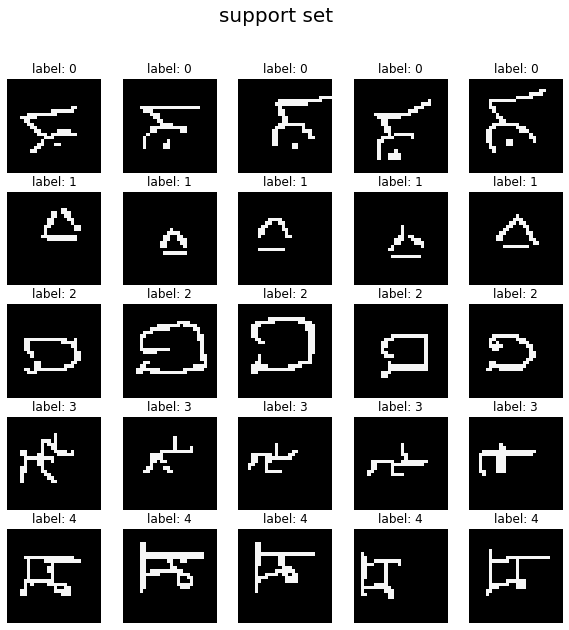

[2020-10-19 00:07:28,302][<ipython-input-6-514a3f127b01>:show_dataloader_data:29][INFO]:support_labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4])
[2020-10-19 00:07:28,347][<ipython-input-6-514a3f127b01>:show_dataloader_data:32][INFO]:query shape: torch.Size([75, 1, 28, 28])


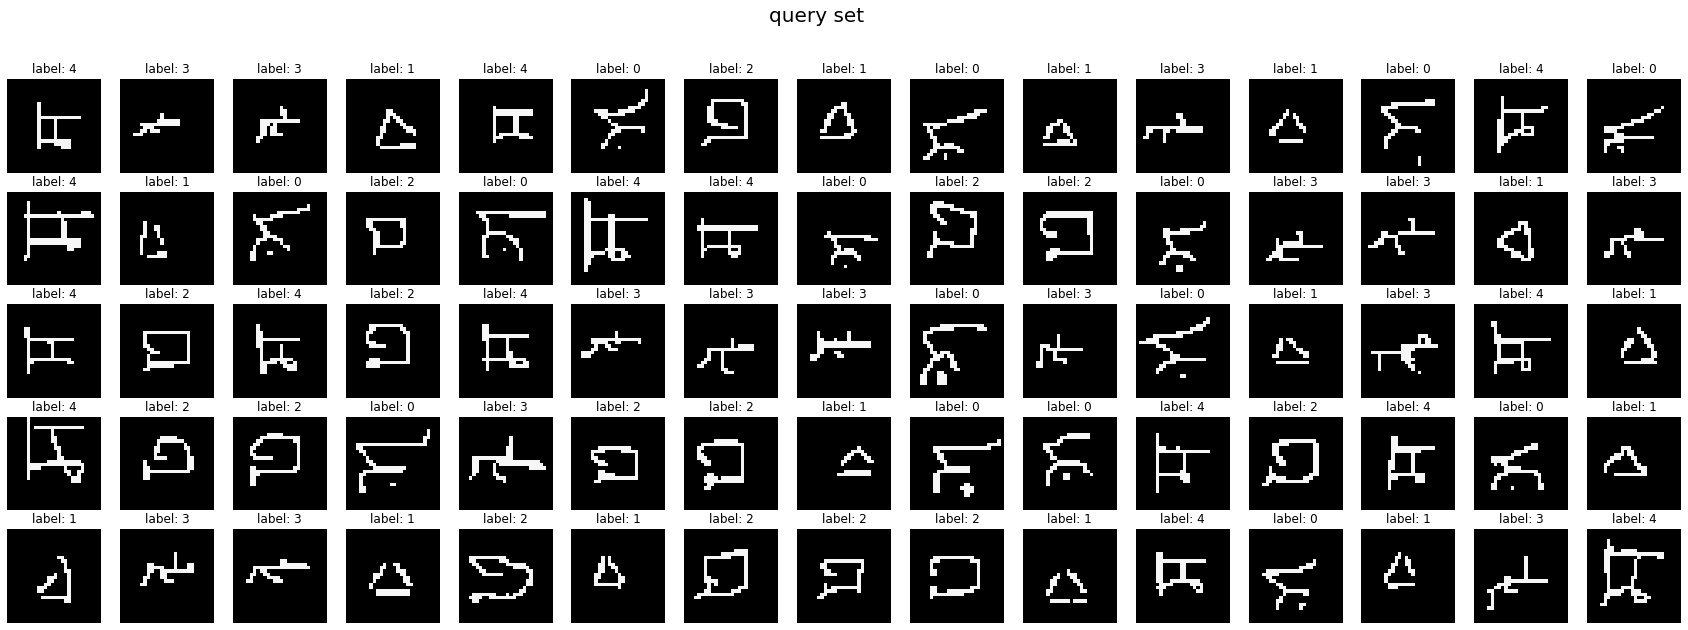

[2020-10-19 00:07:31,968][<ipython-input-6-514a3f127b01>:show_dataloader_data:34][INFO]:query_labels: tensor([4, 3, 3, 1, 4, 0, 2, 1, 0, 1, 3, 1, 0, 4, 0, 4, 1, 0, 2, 0, 4, 4, 0, 2,
        2, 0, 3, 3, 1, 3, 4, 2, 4, 2, 4, 3, 3, 3, 0, 3, 0, 1, 3, 4, 1, 4, 2, 2,
        0, 3, 2, 2, 1, 0, 0, 4, 2, 4, 0, 1, 1, 3, 3, 1, 2, 1, 2, 2, 2, 1, 4, 0,
        1, 3, 4])
[2020-10-19 00:07:31,970][<ipython-input-6-514a3f127b01>:show_dataloader_data:24][INFO]:eposide #1:
[2020-10-19 00:07:31,985][<ipython-input-6-514a3f127b01>:show_dataloader_data:27][INFO]:support shape: torch.Size([25, 1, 28, 28])


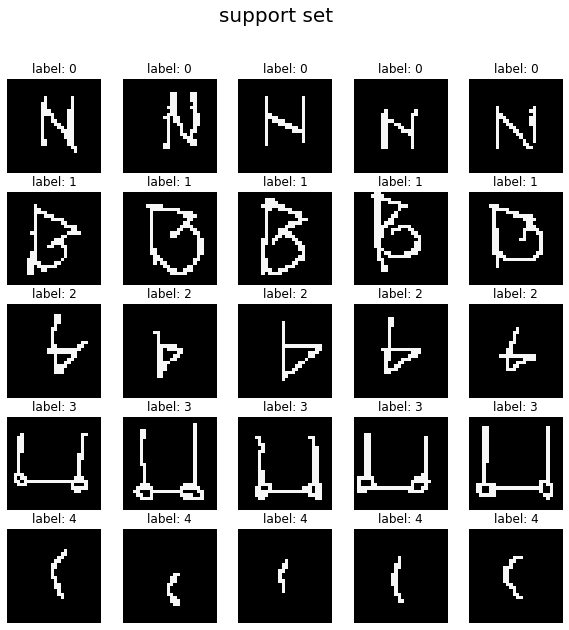

[2020-10-19 00:07:33,288][<ipython-input-6-514a3f127b01>:show_dataloader_data:29][INFO]:support_labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4])
[2020-10-19 00:07:33,328][<ipython-input-6-514a3f127b01>:show_dataloader_data:32][INFO]:query shape: torch.Size([75, 1, 28, 28])


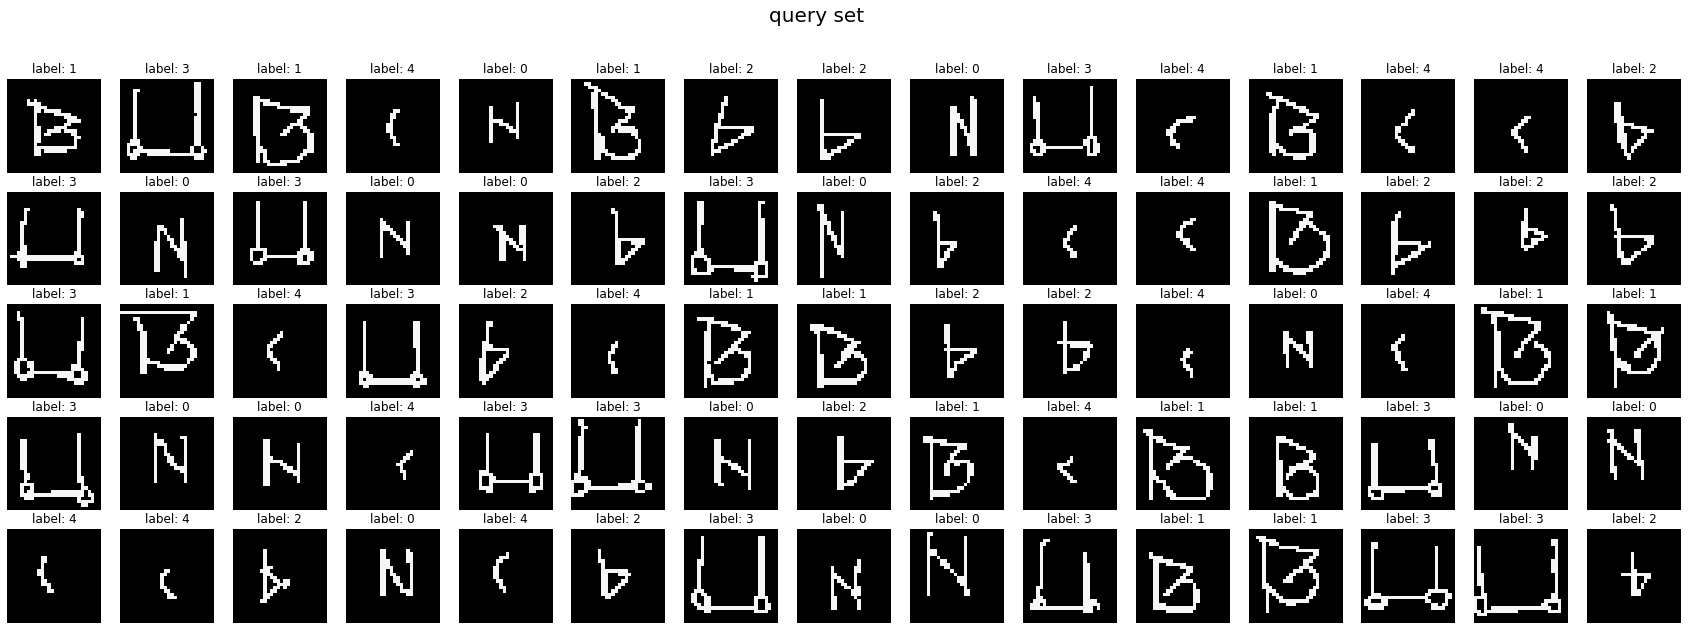

[2020-10-19 00:07:36,882][<ipython-input-6-514a3f127b01>:show_dataloader_data:34][INFO]:query_labels: tensor([1, 3, 1, 4, 0, 1, 2, 2, 0, 3, 4, 1, 4, 4, 2, 3, 0, 3, 0, 0, 2, 3, 0, 2,
        4, 4, 1, 2, 2, 2, 3, 1, 4, 3, 2, 4, 1, 1, 2, 2, 4, 0, 4, 1, 1, 3, 0, 0,
        4, 3, 3, 0, 2, 1, 4, 1, 1, 3, 0, 0, 4, 4, 2, 0, 4, 2, 3, 0, 0, 3, 1, 1,
        3, 3, 2])


In [7]:
show_dataloader_data(omni_metatrain_folders)

## 展示HWDB数据集

[2020-10-19 00:07:36,890][<ipython-input-6-514a3f127b01>:show_dataloader_data:24][INFO]:eposide #0:
[2020-10-19 00:07:36,908][<ipython-input-6-514a3f127b01>:show_dataloader_data:27][INFO]:support shape: torch.Size([25, 1, 28, 28])


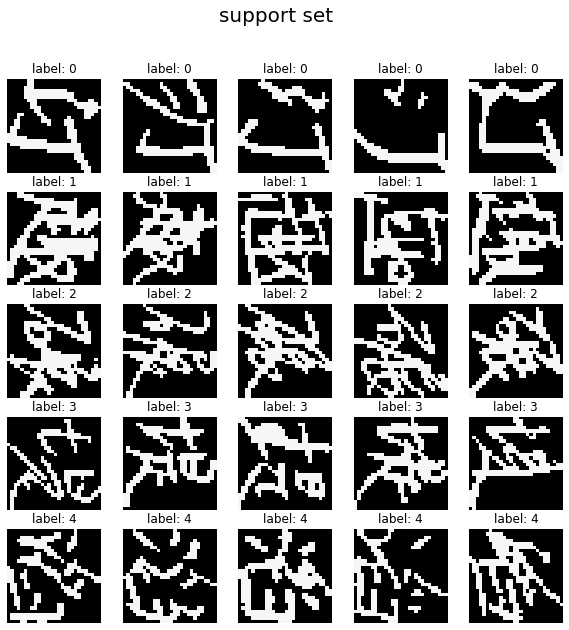

[2020-10-19 00:07:38,234][<ipython-input-6-514a3f127b01>:show_dataloader_data:29][INFO]:support_labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4])
[2020-10-19 00:07:38,281][<ipython-input-6-514a3f127b01>:show_dataloader_data:32][INFO]:query shape: torch.Size([75, 1, 28, 28])


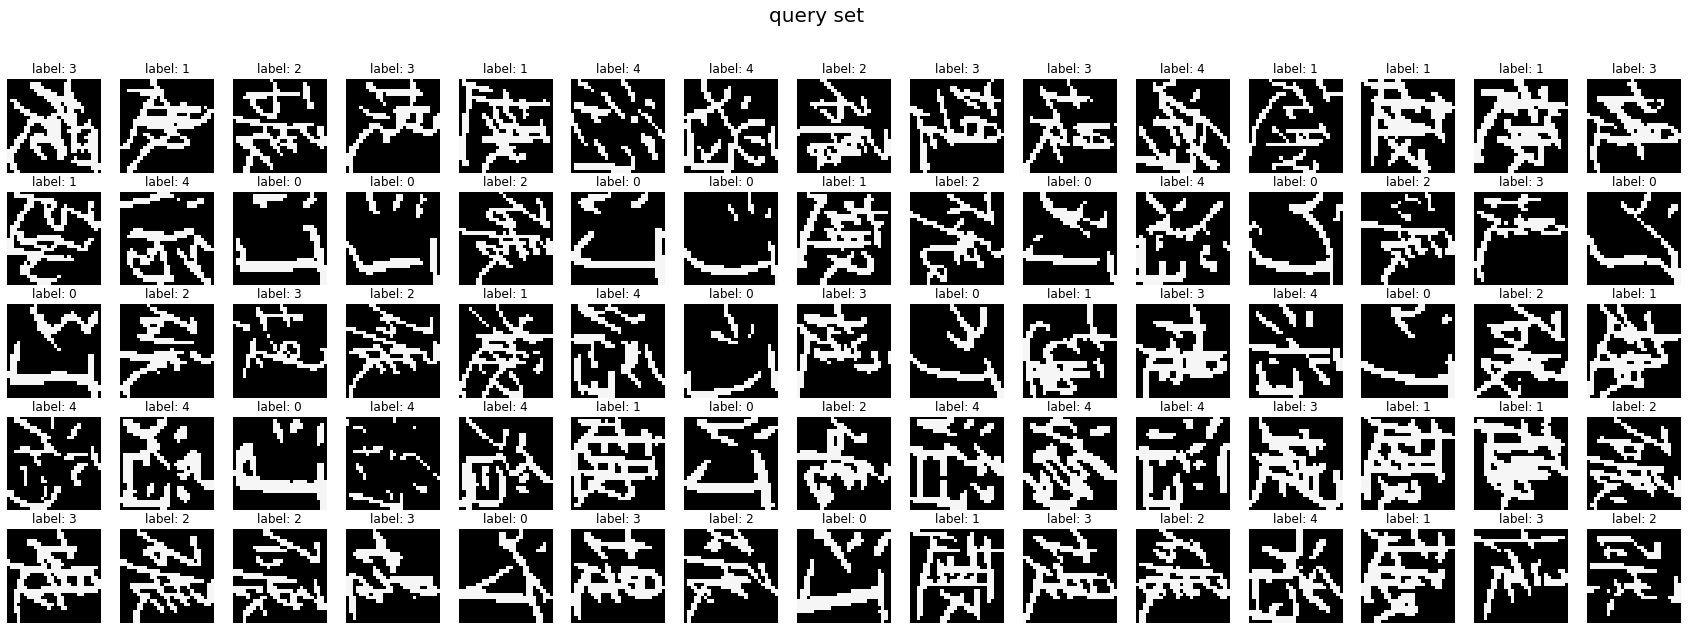

[2020-10-19 00:07:41,852][<ipython-input-6-514a3f127b01>:show_dataloader_data:34][INFO]:query_labels: tensor([3, 1, 2, 3, 1, 4, 4, 2, 3, 3, 4, 1, 1, 1, 3, 1, 4, 0, 0, 2, 0, 0, 1, 2,
        0, 4, 0, 2, 3, 0, 0, 2, 3, 2, 1, 4, 0, 3, 0, 1, 3, 4, 0, 2, 1, 4, 4, 0,
        4, 4, 1, 0, 2, 4, 4, 4, 3, 1, 1, 2, 3, 2, 2, 3, 0, 3, 2, 0, 1, 3, 2, 4,
        1, 3, 2])
[2020-10-19 00:07:41,853][<ipython-input-6-514a3f127b01>:show_dataloader_data:24][INFO]:eposide #1:
[2020-10-19 00:07:41,868][<ipython-input-6-514a3f127b01>:show_dataloader_data:27][INFO]:support shape: torch.Size([25, 1, 28, 28])


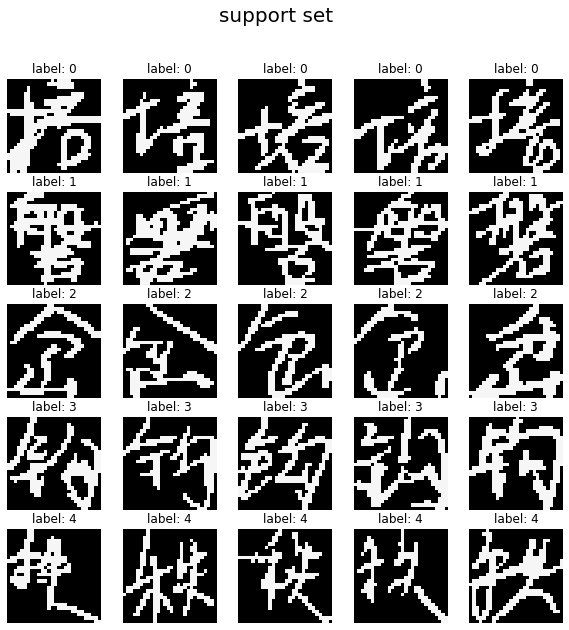

[2020-10-19 00:07:43,231][<ipython-input-6-514a3f127b01>:show_dataloader_data:29][INFO]:support_labels: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4])
[2020-10-19 00:07:43,274][<ipython-input-6-514a3f127b01>:show_dataloader_data:32][INFO]:query shape: torch.Size([75, 1, 28, 28])


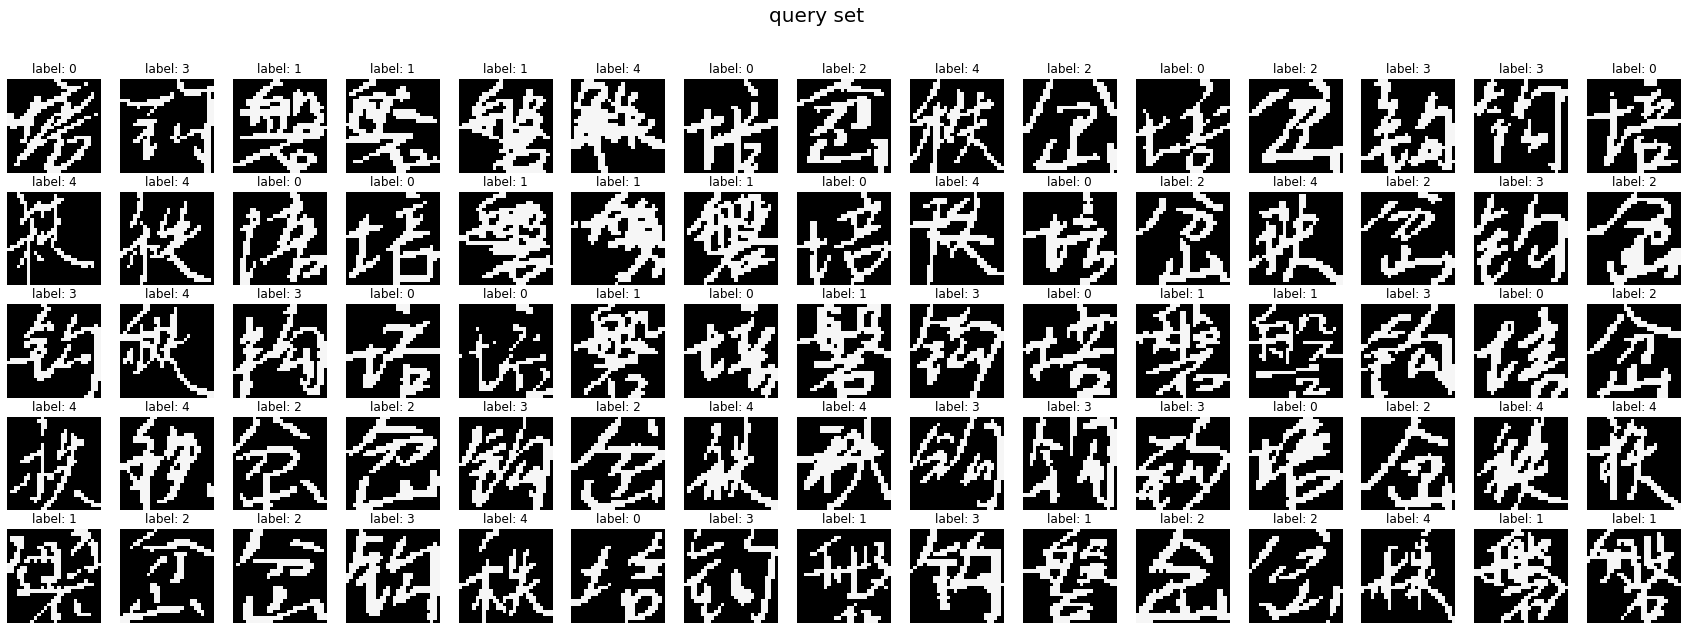

[2020-10-19 00:07:46,850][<ipython-input-6-514a3f127b01>:show_dataloader_data:34][INFO]:query_labels: tensor([0, 3, 1, 1, 1, 4, 0, 2, 4, 2, 0, 2, 3, 3, 0, 4, 4, 0, 0, 1, 1, 1, 0, 4,
        0, 2, 4, 2, 3, 2, 3, 4, 3, 0, 0, 1, 0, 1, 3, 0, 1, 1, 3, 0, 2, 4, 4, 2,
        2, 3, 2, 4, 4, 3, 3, 3, 0, 2, 4, 4, 1, 2, 2, 3, 4, 0, 3, 1, 3, 1, 2, 2,
        4, 1, 1])


In [8]:
show_dataloader_data(hwdb_metatrain_folders)

## 构建网络

### Encoder网络

In [9]:
class CNNEncoder(nn.Module):
    """docstring for ClassName"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size=3, padding=0),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size=3, padding=0),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size=3, padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU())
        self.layer4 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size=3, padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU())

    def forward(self, x):
        # [BATCH_SIZE, 1, IMAGE_SIZE, IMAGE_SIZE] NCHW
        logging.debug("input shape: {}".format(x.shape))
        out = self.layer1(x)
        
        # [BATCH_SIZE, 64, (IMAGE_SIZE-2)/2, (IMAGE_SIZE-2)/2]
        logging.debug("layer1 shape: {}".format(out.shape))
        out = self.layer2(out)
        
        # 除不尽时取整 例如这里((28-2)/2)-2)/2 = 5.5，取5
        # [BATCH_SIZE, 64, ((IMAGE_SIZE-2)/2)-2)/2, ((IMAGE_SIZE-2)/2)-2)/2]
        logging.debug("layer2 shape: {}".format(out.shape))
        out = self.layer3(out)
        
        # [BATCH_SIZE, 64, ((IMAGE_SIZE-2)/2)-2)/2, ((IMAGE_SIZE-2)/2)-2)/2]
        logging.debug("layer3 shape: {}".format(out.shape))
        out = self.layer4(out)
        
        # [BATCH_SIZE, 64, ((IMAGE_SIZE-2)/2)-2)/2, ((IMAGE_SIZE-2)/2)-2)/2]
        logging.debug("layer4 out shape: {}".format(out.shape))
        return out 

### Relation网络

In [10]:
class RelationNetwork(nn.Module):
    """docstring for RelationNetwork"""
    def __init__(self, input_size, hidden_size):
        super(RelationNetwork, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(128, 64, kernel_size=3, padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64, 64, kernel_size=3, padding=1),
                        nn.BatchNorm2d(64, momentum=1, affine=True),
                        nn.ReLU(),
                        nn.MaxPool2d(2))
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # [CLASS_NUM*QUERY_NUM_PER_CLASS*CLASS_NUM, FEATURE_DIM*2, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE]
        logging.debug("input shape: {}".format(x.shape))
        out = self.layer1(x)
        logging.debug("layer1 out shape: {}".format(out.shape))
        out = self.layer2(out)
        logging.debug("layer2 out shape: {}".format(out.shape))
        # [CLASS_NUM*QUERY_NUM_PER_CLASS*CLASS_NUM, FEATURE_DIM]
        # [x.shape[0], x.shape[1]/2]
        out = out.view(out.size(0), -1 )
        logging.debug("view out shape: {}".format(out.shape))
        # [CLASS_NUM*QUERY_NUM_PER_CLASS*CLASS_NUM, hidden_size]
        # [x.shape[0], hidden_size]
        out = F.relu(self.fc1(out))
        logging.debug("fc1 out shape: {}".format(out.shape))
        # [CLASS_NUM*QUERY_NUM_PER_CLASS*CLASS_NUM, 1]
        # [x.shape[0], 1]
        out = torch.sigmoid(self.fc2(out))
        logging.debug("fc2 out shape: {}".format(out.shape))
        return out

### 网络初始化

In [11]:
def weights_init(m):
    # 当前nn.module的名字
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # 如果是卷积
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        # 初始化卷积核参数为正态分布 均值为0 方差为math.sqrt(2. / n)
        m.weight.data.normal_(0, math.sqrt(2. / n))
        # 初始化偏置项参数为0
        if m.bias is not None:
            m.bias.data.zero_()
    elif classname.find('BatchNorm') != -1:
        # 如果是BatchNorm
        # 初始化权重为1
        m.weight.data.fill_(1)
        # 初始化偏置为0
        m.bias.data.zero_()
    elif classname.find('Linear') != -1:
        # 如果是Linear
        #n = m.weight.size(1)
        # 初始化权重为正态分布 均值为0 方差为0.01
        m.weight.data.normal_(0, 0.01)
        # 初始化偏置为1
        m.bias.data = torch.ones(m.bias.data.size())


def load_model(feature_encoder, relation_network, model_dir):
    init_flag = False
    #cur_model_dir = os.path.joins(model_dir, "{}_way_{}_shot".format(class_num, support_num_per_class))
    if os.path.isdir(model_dir):
        feature_encoder_model_path = os.path.join(model_dir, "omniglot_feature_encoder.pkl")
        relation_network_model_path = os.path.join(model_dir, "omniglot_relation_network.pkl")
        if os.path.exists(feature_encoder_model_path) and os.path.exists(relation_network_model_path):
            feature_encoder.load_state_dict(torch.load(feature_encoder_model_path))
            relation_network.load_state_dict(torch.load(relation_network_model_path))
            init_flag = True    
    return init_flag


def save_model(feature_encoder, relation_network, model_dir):
    # 清空该文件夹
    if os.path.isdir(model_dir):
        shutil.rmtree(model_dir)
    os.makedirs(model_dir)
    
    # save networks
    torch.save(feature_encoder.state_dict(),
               os.path.join(model_dir, "omniglot_feature_encoder.pkl"))
    
    torch.save(relation_network.state_dict(),
               os.path.join(model_dir, "omniglot_relation_network.pkl"))


def init_model(model_dir):
    feature_encoder = CNNEncoder()
    relation_network = RelationNetwork(FEATURE_DIM, RELATION_DIM)

    #logging.info("\n{}".format(feature_encoder))
    #logging.info("\n{}".format(relation_network))
    
    cur_model_dir = os.path.join(model_dir, "{}_way_{}_shot".format(CLASS_NUM, SUPPORT_NUM_PER_CLASS))
    if load_model(feature_encoder, relation_network, cur_model_dir):
        logging.info("model load from {}".format(cur_model_dir))
    else:
        logging.warning("cannot find model from {}".format(cur_model_dir))
        feature_encoder.apply(weights_init)
        relation_network.apply(weights_init)

    feature_encoder.cuda(GPU)
    relation_network.cuda(GPU)
    
    feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(), lr=LEARNING_RATE)
    feature_encoder_scheduler = StepLR(feature_encoder_optim, step_size=LR_STEP_SIZE, gamma=LR_STEP_GAMMA)
    
    relation_network_optim = torch.optim.Adam(relation_network.parameters(), lr=LEARNING_RATE)
    relation_network_scheduler = StepLR(relation_network_optim, step_size=LR_STEP_SIZE, gamma=LR_STEP_GAMMA)
    
    return {
        "feature_encoder": feature_encoder,
        "relation_network": relation_network,
        "feature_encoder_optim": feature_encoder_optim,
        "feature_encoder_scheduler": feature_encoder_scheduler,
        "relation_network_optim": relation_network_optim,
        "relation_network_scheduler": relation_network_scheduler,
        "model_dir": model_dir,
    }

omni_model_dict = init_model(OMNI_MODEL_DIR)
hwdb_model_dict = init_model(HWDB_MODEL_DIR)

[2020-10-19 00:07:46,903][<ipython-input-11-5842884d8011>:init_model:65][WARNING]:cannot find model from ./models_modify/omniglot/5_way_5_shot
[2020-10-19 00:07:50,647][<ipython-input-11-5842884d8011>:init_model:65][WARNING]:cannot find model from ./models_modify/hwdb/5_way_5_shot


## 模型训练

### 模型训练、评估函数

In [12]:
def pred(support, query,
         feature_encoder, relation_network,
         class_num, support_num_per_class, query_num_per_class, feature_dim, gpu_id):
    # calculate features
    logging.debug("support shape: {}".format(support.shape))
    logging.debug("query shape: {}".format(query.shape))
    
    # 计算support集中每类每个样本的特征
    # [CLASS_NUM*support_num_per_class, FEATURE_DIM, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE]
    support_features = feature_encoder(Variable(support).cuda(gpu_id))
    logging.debug("support_features shape: {}".format(support_features.shape))
    
    # 将各样本按类别划分
    # [CLASS_NUM, support_num_per_class, FEATURE_DIM, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE]
    support_features = support_features.view(class_num, support_num_per_class, feature_dim,
                                           ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE)
    logging.debug("support_features view shape: {}".format(support_features.shape))
    
    # 同类别样本的特征相加 得到support集中每个类别的特征矩阵
    # [CLASS_NUM, FEATURE_DIM, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE]
    support_features = torch.sum(support_features, 1).squeeze(1)
    logging.debug("support_features sum shape: {}".format(support_features.shape))
    
    # 计算query集中每类每个样本的特征
    # [CLASS_NUM*query_num_per_class, FEATURE_DIM, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE]
    query_features = feature_encoder(Variable(query).cuda(gpu_id))
    logging.debug("query_features shape: {}".format(query_features.shape))
    
    # calculate relations
    # each query support link to every support to calculate relations
    # to form a 100x128 matrix for relation network
    
    # support集各类的特征矩阵重复，次数等于query集中样本数
    # [query_num_per_class*CLASS_NUM, CLASS_NUM, FEATURE_DIM, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE]
    support_features_ext = support_features.unsqueeze(0).repeat(query_num_per_class * class_num, 1, 1, 1, 1)
    logging.debug("support_features_ext shape: {}".format(support_features_ext.shape))
    
    # query集各样本的特征矩阵重复，次数等于support集的类别数
    # [CLASS_NUM, CLASS_NUM*query_num_per_class, FEATURE_DIM, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE]
    query_features_ext = query_features.unsqueeze(0).repeat(class_num, 1, 1, 1, 1)
    logging.debug("query_features_ext shape: {}".format(query_features_ext.shape))
    
    # [CLASS_NUM*query_num_per_class, CLASS_NUM, FEATURE_DIM, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE]
    query_features_ext = torch.transpose(query_features_ext, 0, 1)
    logging.debug("query_features_ext transpose shape: {}".format(query_features_ext.shape))
    
    # query集中各样本的特征矩阵和support集中各类的特征矩阵配对连接，因此配对数=query集的样本数*support集的类别数
    # [CLASS_NUM*query_num_per_class*CLASS_NUM, FEATURE_DIM*2, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE]
    relation_pairs = torch.cat((support_features_ext, query_features_ext), 2)\
                          .view(-1, feature_dim*2, ENCODE_FEATURE_SIZE, ENCODE_FEATURE_SIZE)
    logging.debug("relation_pairs shape: {}".format(relation_pairs.shape))
    
    # 根据各配对的特征矩阵给各配对打分
    # [CLASS_NUM*query_num_per_class*CLASS_NUM, 1]
    relations = relation_network(relation_pairs)
    
    # 将打分划分为query集中各样本关于support集中各类的配对分数
    # [CLASS_NUM*query_num_per_class, CLASS_NUM]
    relations = relations.view(-1, class_num)
    logging.debug("relations shape: {}".format(relations.shape))
    
    return relations
    
def evaluate(folders, feature_encoder, relation_network):
    total_rewards = 0

    generator = DataLoaderGenerator(folders, CLASS_NUM, SUPPORT_NUM_PER_CLASS, SUPPORT_NUM_PER_CLASS)
    for episode in range(TEST_EPISODE):
        support_dataloader, query_dataloader = generator.gen_data_loader()
        
        for (support, support_labels), (query, query_labels) in zip(support_dataloader, query_dataloader):
            relations = pred(support, query,
                             feature_encoder, relation_network,
                             CLASS_NUM, SUPPORT_NUM_PER_CLASS, SUPPORT_NUM_PER_CLASS, FEATURE_DIM, GPU)
    
            _, predict_labels = torch.max(relations.data, 1)
            logging.debug("predict_labels: {}".format(predict_labels))

            rewards = [1 if predict_labels[j] == query_labels[j] else 0 for j in \
                       range(CLASS_NUM * SUPPORT_NUM_PER_CLASS)]

            total_rewards += np.sum(rewards)
        
        #if (episode + 1) % 100 == 0:
        #    logging.info("eval episode: {}, cur rewards: {}, query num: {}"\
        #                 .format(episode + 1, total_rewards, CLASS_NUM * SUPPORT_NUM_PER_CLASS * (episode + 1)))

    total_query_num = CLASS_NUM * SUPPORT_NUM_PER_CLASS * TEST_EPISODE
    query_accuracy = total_rewards / float(total_query_num)
    
    logging.info("eval accuracy: {:.6f}({}/{})".format(query_accuracy, total_rewards, total_query_num))
    return query_accuracy
    
def train(folders, eval_folders, model_dict):
    feature_encoder            = model_dict["feature_encoder"]
    relation_network           = model_dict["relation_network"]
    feature_encoder_optim      = model_dict["feature_encoder_optim"]
    feature_encoder_scheduler  = model_dict["feature_encoder_scheduler"]
    relation_network_optim     = model_dict["relation_network_optim"]
    relation_network_scheduler = model_dict["relation_network_scheduler"]
    model_dir                  = model_dict["model_dir"]
    
    best_accuracy = 0.0
    
    mse = nn.MSELoss().cuda(GPU)
    
    generator = DataLoaderGenerator(folders, CLASS_NUM, SUPPORT_NUM_PER_CLASS, QUERY_NUM_PER_CLASS)
    for episode in range(EPISODE):
        support_dataloader, query_dataloader = generator.gen_data_loader()
        
        for (support, support_labels), (query, query_labels) in zip(support_dataloader, query_dataloader):
            # calculate features
            relations = pred(support, query,
                             feature_encoder, relation_network,
                             CLASS_NUM, SUPPORT_NUM_PER_CLASS, QUERY_NUM_PER_CLASS, FEATURE_DIM, GPU)
            
            # 构造query_labels的one_hot形式
            one_hot_labels = Variable(torch.zeros(QUERY_NUM_PER_CLASS*CLASS_NUM, CLASS_NUM)\
                                      .scatter_(1, query_labels.view(-1, 1), 1)).cuda(GPU)
            logging.debug("one_hot_labels shape: {}".format(one_hot_labels.shape))
            
            loss = mse(relations, one_hot_labels)
            
            feature_encoder.zero_grad()
            relation_network.zero_grad()
    
            loss.backward()
    
            torch.nn.utils.clip_grad_norm_(feature_encoder.parameters(), 0.5)
            torch.nn.utils.clip_grad_norm_(relation_network.parameters(), 0.5)
    
            feature_encoder_optim.step()
            relation_network_optim.step()
        
        feature_encoder_scheduler.step()
        relation_network_scheduler.step()

        if (episode + 1) % LOSS_PRINT_STEP == 0:
            logging.info("episode: {}, loss = {:.6f}".format(episode + 1, loss.data))
                
        if (episode + 1) % EVAL_STEP == 0:
            query_accuracy = evaluate(eval_folders, feature_encoder, relation_network)
            if query_accuracy > best_accuracy:
                logging.info("eposide {}'s query accuracy({:.6f}) > prev query accuracy({:.6f}), save cur model"\
                             .format(episode + 1, query_accuracy, best_accuracy))
                
                cur_model_dir = os.path.join(model_dir, "{}_way_{}_shot".format(CLASS_NUM,
                                                                                 SUPPORT_NUM_PER_CLASS))
                save_model(feature_encoder, relation_network, cur_model_dir)

                best_accuracy = query_accuracy

## Omniglot数据集训练

In [13]:
train(omni_metatrain_folders, omni_metaeval_folders, omni_model_dict)

[2020-10-19 00:07:58,110][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 100, loss = 0.106964
[2020-10-19 00:08:05,519][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 200, loss = 0.086283
[2020-10-19 00:08:13,003][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 300, loss = 0.057856
[2020-10-19 00:08:20,616][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 400, loss = 0.025473
[2020-10-19 00:08:28,154][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 500, loss = 0.049517
[2020-10-19 00:08:35,544][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 600, loss = 0.027052
[2020-10-19 00:08:42,973][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 700, loss = 0.027851
[2020-10-19 00:08:50,449][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 800, loss = 0.026733
[2020-10-19 00:08:57,886][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 900, loss = 0.019152
[2020-10-19 00:09:05,466][<ipython-input-12-42c863e6d0e

[2020-10-19 00:18:04,274][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 7600, loss = 0.002279
[2020-10-19 00:18:11,736][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 7700, loss = 0.053349
[2020-10-19 00:18:19,897][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 7800, loss = 0.047559
[2020-10-19 00:18:27,627][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 7900, loss = 0.003510
[2020-10-19 00:18:35,382][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8000, loss = 0.005778
[2020-10-19 00:18:42,821][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8100, loss = 0.008497
[2020-10-19 00:18:50,254][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8200, loss = 0.010817
[2020-10-19 00:18:58,367][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8300, loss = 0.009629
[2020-10-19 00:19:06,129][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8400, loss = 0.001773
[2020-10-19 00:19:13,729][<ipython-input-12-42

[2020-10-19 00:28:38,558][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.993680(24842/25000)
[2020-10-19 00:28:46,176][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15100, loss = 0.013556
[2020-10-19 00:28:53,642][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15200, loss = 0.005954
[2020-10-19 00:29:01,161][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15300, loss = 0.018275
[2020-10-19 00:29:08,696][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15400, loss = 0.004236
[2020-10-19 00:29:16,226][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15500, loss = 0.014008
[2020-10-19 00:29:23,924][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15600, loss = 0.000190
[2020-10-19 00:29:31,429][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15700, loss = 0.006976
[2020-10-19 00:29:38,920][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15800, loss = 0.004629
[2020-10-19 00:29:46,308][<ipy

[2020-10-19 00:38:36,895][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22400, loss = 0.002913
[2020-10-19 00:38:44,955][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22500, loss = 0.005290
[2020-10-19 00:38:53,511][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22600, loss = 0.002715
[2020-10-19 00:39:02,049][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22700, loss = 0.005460
[2020-10-19 00:39:10,546][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22800, loss = 0.027709
[2020-10-19 00:39:18,554][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22900, loss = 0.011751
[2020-10-19 00:39:26,067][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 23000, loss = 0.008017
[2020-10-19 00:39:33,566][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 23100, loss = 0.003147
[2020-10-19 00:39:41,173][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 23200, loss = 0.017123
[2020-10-19 00:39:48,638][<ipython-in

[2020-10-19 00:49:01,319][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 30000, loss = 0.002878
[2020-10-19 00:49:35,701][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.995960(24899/25000)
[2020-10-19 00:49:35,704][<ipython-input-12-42c863e6d0ef>:train:145][INFO]:eposide 30000's query accuracy(0.995960) > prev query accuracy(0.995960), save cur model
[2020-10-19 00:49:43,195][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 30100, loss = 0.003672
[2020-10-19 00:49:50,968][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 30200, loss = 0.004699
[2020-10-19 00:49:58,577][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 30300, loss = 0.003394
[2020-10-19 00:50:06,012][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 30400, loss = 0.001974
[2020-10-19 00:50:13,665][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 30500, loss = 0.001762
[2020-10-19 00:50:21,377][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episo

[2020-10-19 00:59:55,134][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37600, loss = 0.013355
[2020-10-19 01:00:02,615][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37700, loss = 0.000038
[2020-10-19 01:00:10,044][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37800, loss = 0.000557
[2020-10-19 01:00:17,446][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37900, loss = 0.000167
[2020-10-19 01:00:24,913][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 38000, loss = 0.000253
[2020-10-19 01:00:32,538][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 38100, loss = 0.001377
[2020-10-19 01:00:39,983][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 38200, loss = 0.002357
[2020-10-19 01:00:47,384][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 38300, loss = 0.000402
[2020-10-19 01:00:54,802][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 38400, loss = 0.002399
[2020-10-19 01:01:02,427][<ipython-in

[2020-10-19 01:10:39,894][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45100, loss = 0.002972
[2020-10-19 01:10:47,406][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45200, loss = 0.001016
[2020-10-19 01:10:54,852][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45300, loss = 0.005760
[2020-10-19 01:11:02,380][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45400, loss = 0.000113
[2020-10-19 01:11:09,868][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45500, loss = 0.002921
[2020-10-19 01:11:17,450][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45600, loss = 0.000467
[2020-10-19 01:11:24,882][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45700, loss = 0.003751
[2020-10-19 01:11:32,254][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45800, loss = 0.000086
[2020-10-19 01:11:39,687][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45900, loss = 0.000108
[2020-10-19 01:11:47,342][<ipython-in

[2020-10-19 01:20:49,365][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52700, loss = 0.005280
[2020-10-19 01:20:57,905][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52800, loss = 0.009280
[2020-10-19 01:21:06,423][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52900, loss = 0.000883
[2020-10-19 01:21:14,993][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 53000, loss = 0.003358
[2020-10-19 01:21:23,605][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 53100, loss = 0.009840
[2020-10-19 01:21:31,734][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 53200, loss = 0.000011
[2020-10-19 01:21:39,687][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 53300, loss = 0.000194
[2020-10-19 01:21:48,200][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 53400, loss = 0.022382
[2020-10-19 01:21:56,780][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 53500, loss = 0.004894
[2020-10-19 01:22:05,342][<ipython-in

[2020-10-19 01:31:40,653][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 60200, loss = 0.002686
[2020-10-19 01:31:48,119][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 60300, loss = 0.001654
[2020-10-19 01:31:55,637][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 60400, loss = 0.001220
[2020-10-19 01:32:03,114][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 60500, loss = 0.000082
[2020-10-19 01:32:10,549][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 60600, loss = 0.001055
[2020-10-19 01:32:18,002][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 60700, loss = 0.003112
[2020-10-19 01:32:25,562][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 60800, loss = 0.004671
[2020-10-19 01:32:32,958][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 60900, loss = 0.002444
[2020-10-19 01:32:40,354][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 61000, loss = 0.001603
[2020-10-19 01:32:47,954][<ipython-in

[2020-10-19 01:41:41,619][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 67600, loss = 0.033470
[2020-10-19 01:41:48,969][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 67700, loss = 0.000276
[2020-10-19 01:41:56,581][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 67800, loss = 0.004236
[2020-10-19 01:42:04,161][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 67900, loss = 0.000323
[2020-10-19 01:42:11,663][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 68000, loss = 0.001748
[2020-10-19 01:42:19,799][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 68100, loss = 0.000760
[2020-10-19 01:42:27,494][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 68200, loss = 0.000988
[2020-10-19 01:42:35,110][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 68300, loss = 0.000096
[2020-10-19 01:42:42,439][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 68400, loss = 0.002796
[2020-10-19 01:42:49,925][<ipython-in

[2020-10-19 01:52:07,582][<ipython-input-12-42c863e6d0ef>:train:145][INFO]:eposide 75000's query accuracy(0.996480) > prev query accuracy(0.996480), save cur model
[2020-10-19 01:52:15,039][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 75100, loss = 0.007759
[2020-10-19 01:52:22,656][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 75200, loss = 0.000480
[2020-10-19 01:52:30,103][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 75300, loss = 0.001686
[2020-10-19 01:52:37,619][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 75400, loss = 0.001615
[2020-10-19 01:52:45,150][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 75500, loss = 0.001743
[2020-10-19 01:52:52,656][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 75600, loss = 0.000806
[2020-10-19 01:53:00,153][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 75700, loss = 0.009146
[2020-10-19 01:53:07,520][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 758

[2020-10-19 02:02:10,704][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 82500, loss = 0.006608
[2020-10-19 02:02:18,395][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 82600, loss = 0.000073
[2020-10-19 02:02:26,135][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 82700, loss = 0.000161
[2020-10-19 02:02:33,582][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 82800, loss = 0.002549
[2020-10-19 02:02:41,087][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 82900, loss = 0.001161
[2020-10-19 02:02:48,513][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 83000, loss = 0.000002
[2020-10-19 02:02:55,906][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 83100, loss = 0.005525
[2020-10-19 02:03:03,409][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 83200, loss = 0.000066
[2020-10-19 02:03:10,842][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 83300, loss = 0.000157
[2020-10-19 02:03:18,272][<ipython-in

[2020-10-19 02:12:01,942][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 89900, loss = 0.000004
[2020-10-19 02:12:09,383][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 90000, loss = 0.000565
[2020-10-19 02:12:43,799][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.996400(24910/25000)
[2020-10-19 02:12:51,331][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 90100, loss = 0.017374
[2020-10-19 02:12:58,709][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 90200, loss = 0.000069
[2020-10-19 02:13:06,315][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 90300, loss = 0.000739
[2020-10-19 02:13:13,942][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 90400, loss = 0.001263
[2020-10-19 02:13:21,377][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 90500, loss = 0.000004
[2020-10-19 02:13:28,739][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 90600, loss = 0.011320
[2020-10-19 02:13:36,190][<ipy

[2020-10-19 02:22:40,559][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 97400, loss = 0.000014
[2020-10-19 02:22:47,929][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 97500, loss = 0.000003
[2020-10-19 02:22:55,257][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 97600, loss = 0.005855
[2020-10-19 02:23:02,608][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 97700, loss = 0.002585
[2020-10-19 02:23:10,486][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 97800, loss = 0.005118
[2020-10-19 02:23:17,907][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 97900, loss = 0.000170
[2020-10-19 02:23:25,404][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 98000, loss = 0.000076
[2020-10-19 02:23:32,908][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 98100, loss = 0.002927
[2020-10-19 02:23:41,463][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 98200, loss = 0.001452
[2020-10-19 02:23:49,932][<ipython-in

[2020-10-19 02:32:51,813][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 105000, loss = 0.000488
[2020-10-19 02:33:26,192][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.997120(24928/25000)
[2020-10-19 02:33:26,194][<ipython-input-12-42c863e6d0ef>:train:145][INFO]:eposide 105000's query accuracy(0.997120) > prev query accuracy(0.997120), save cur model
[2020-10-19 02:33:33,728][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 105100, loss = 0.000094
[2020-10-19 02:33:41,439][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 105200, loss = 0.000004
[2020-10-19 02:33:48,815][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 105300, loss = 0.002668
[2020-10-19 02:33:56,491][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 105400, loss = 0.000018
[2020-10-19 02:34:04,291][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 105500, loss = 0.000865
[2020-10-19 02:34:11,658][<ipython-input-12-42c863e6d0ef>:train:139][INFO

[2020-10-19 02:43:13,432][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 112300, loss = 0.002153
[2020-10-19 02:43:21,075][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 112400, loss = 0.000110
[2020-10-19 02:43:28,563][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 112500, loss = 0.000585
[2020-10-19 02:43:36,001][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 112600, loss = 0.001236
[2020-10-19 02:43:43,589][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 112700, loss = 0.000761
[2020-10-19 02:43:51,476][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 112800, loss = 0.000448
[2020-10-19 02:43:58,899][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 112900, loss = 0.000006
[2020-10-19 02:44:07,255][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 113000, loss = 0.005032
[2020-10-19 02:44:15,771][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 113100, loss = 0.000056
[2020-10-19 02:44:24,335][<i

[2020-10-19 02:53:16,511][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 119800, loss = 0.000333
[2020-10-19 02:53:24,262][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 119900, loss = 0.004492
[2020-10-19 02:53:31,769][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 120000, loss = 0.001692
[2020-10-19 02:54:06,201][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.996240(24906/25000)
[2020-10-19 02:54:13,651][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 120100, loss = 0.002179
[2020-10-19 02:54:21,268][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 120200, loss = 0.000647
[2020-10-19 02:54:28,827][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 120300, loss = 0.000282
[2020-10-19 02:54:36,298][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 120400, loss = 0.002046
[2020-10-19 02:54:43,821][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 120500, loss = 0.050502
[2020-10-19 02:54:51,2

[2020-10-19 03:03:47,182][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 127200, loss = 0.000995
[2020-10-19 03:03:54,665][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 127300, loss = 0.000226
[2020-10-19 03:04:02,278][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 127400, loss = 0.000401
[2020-10-19 03:04:09,727][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 127500, loss = 0.000386
[2020-10-19 03:04:17,196][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 127600, loss = 0.002369
[2020-10-19 03:04:25,012][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 127700, loss = 0.002810
[2020-10-19 03:04:32,629][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 127800, loss = 0.001772
[2020-10-19 03:04:40,383][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 127900, loss = 0.010038
[2020-10-19 03:04:47,824][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 128000, loss = 0.000011
[2020-10-19 03:04:55,258][<i

[2020-10-19 03:13:48,440][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 134700, loss = 0.002672
[2020-10-19 03:13:55,921][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 134800, loss = 0.007963
[2020-10-19 03:14:03,478][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 134900, loss = 0.000015
[2020-10-19 03:14:10,847][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 135000, loss = 0.005608
[2020-10-19 03:14:45,052][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.996800(24920/25000)
[2020-10-19 03:14:52,437][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 135100, loss = 0.000116
[2020-10-19 03:15:00,290][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 135200, loss = 0.014546
[2020-10-19 03:15:07,724][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 135300, loss = 0.000006
[2020-10-19 03:15:15,109][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 135400, loss = 0.004882
[2020-10-19 03:15:22,8

[2020-10-19 03:24:18,737][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 142100, loss = 0.000098
[2020-10-19 03:24:26,197][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 142200, loss = 0.000843
[2020-10-19 03:24:33,597][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 142300, loss = 0.000585
[2020-10-19 03:24:41,005][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 142400, loss = 0.001456
[2020-10-19 03:24:48,544][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 142500, loss = 0.000037
[2020-10-19 03:24:56,482][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 142600, loss = 0.000001
[2020-10-19 03:25:04,024][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 142700, loss = 0.000066
[2020-10-19 03:25:11,390][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 142800, loss = 0.000103
[2020-10-19 03:25:18,993][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 142900, loss = 0.003363
[2020-10-19 03:25:26,433][<i

[2020-10-19 03:34:11,463][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 149500, loss = 0.002347
[2020-10-19 03:34:19,010][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 149600, loss = 0.007987
[2020-10-19 03:34:26,644][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 149700, loss = 0.000420
[2020-10-19 03:34:34,127][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 149800, loss = 0.000984
[2020-10-19 03:34:41,573][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 149900, loss = 0.000002
[2020-10-19 03:34:49,011][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 150000, loss = 0.009255
[2020-10-19 03:35:23,457][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.996560(24914/25000)


## HWDB数据集训练

In [14]:
train(hwdb_metatrain_folders, hwdb_metaeval_folders, hwdb_model_dict)

[2020-10-19 03:35:31,254][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 100, loss = 0.159147
[2020-10-19 03:35:39,004][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 200, loss = 0.100480
[2020-10-19 03:35:46,720][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 300, loss = 0.068439
[2020-10-19 03:35:54,482][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 400, loss = 0.086540
[2020-10-19 03:36:02,434][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 500, loss = 0.041119
[2020-10-19 03:36:10,143][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 600, loss = 0.089004
[2020-10-19 03:36:17,934][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 700, loss = 0.025511
[2020-10-19 03:36:25,988][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 800, loss = 0.052072
[2020-10-19 03:36:33,741][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 900, loss = 0.051132
[2020-10-19 03:36:41,697][<ipython-input-12-42c863e6d0e

[2020-10-19 03:46:03,209][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 7600, loss = 0.011982
[2020-10-19 03:46:11,073][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 7700, loss = 0.009475
[2020-10-19 03:46:18,884][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 7800, loss = 0.025969
[2020-10-19 03:46:26,969][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 7900, loss = 0.010619
[2020-10-19 03:46:34,785][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8000, loss = 0.020497
[2020-10-19 03:46:42,528][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8100, loss = 0.025099
[2020-10-19 03:46:50,317][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8200, loss = 0.036696
[2020-10-19 03:46:58,497][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8300, loss = 0.031218
[2020-10-19 03:47:06,493][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 8400, loss = 0.008156
[2020-10-19 03:47:14,237][<ipython-input-12-42

[2020-10-19 03:57:10,230][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.979640(24491/25000)
[2020-10-19 03:57:10,232][<ipython-input-12-42c863e6d0ef>:train:145][INFO]:eposide 15000's query accuracy(0.979640) > prev query accuracy(0.979640), save cur model
[2020-10-19 03:57:18,114][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15100, loss = 0.019511
[2020-10-19 03:57:25,977][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15200, loss = 0.010891
[2020-10-19 03:57:33,750][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15300, loss = 0.013490
[2020-10-19 03:57:41,807][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15400, loss = 0.013353
[2020-10-19 03:57:49,663][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15500, loss = 0.009777
[2020-10-19 03:57:57,499][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 15600, loss = 0.013278
[2020-10-19 03:58:05,310][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episo

[2020-10-19 04:07:26,788][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22300, loss = 0.053525
[2020-10-19 04:07:34,589][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22400, loss = 0.009754
[2020-10-19 04:07:42,358][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22500, loss = 0.037792
[2020-10-19 04:07:50,288][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22600, loss = 0.037812
[2020-10-19 04:07:58,136][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22700, loss = 0.002870
[2020-10-19 04:08:06,150][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22800, loss = 0.035627
[2020-10-19 04:08:13,999][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 22900, loss = 0.030340
[2020-10-19 04:08:21,920][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 23000, loss = 0.004266
[2020-10-19 04:08:29,685][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 23100, loss = 0.008786
[2020-10-19 04:08:37,890][<ipython-in

[2020-10-19 04:17:47,911][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 29700, loss = 0.015387
[2020-10-19 04:17:55,747][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 29800, loss = 0.008822
[2020-10-19 04:18:03,490][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 29900, loss = 0.005632
[2020-10-19 04:18:11,260][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 30000, loss = 0.017194
[2020-10-19 04:18:47,191][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.985200(24630/25000)
[2020-10-19 04:18:47,194][<ipython-input-12-42c863e6d0ef>:train:145][INFO]:eposide 30000's query accuracy(0.985200) > prev query accuracy(0.985200), save cur model
[2020-10-19 04:18:54,951][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 30100, loss = 0.009062
[2020-10-19 04:19:02,752][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 30200, loss = 0.011634
[2020-10-19 04:19:10,590][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episo

[2020-10-19 04:28:33,204][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37000, loss = 0.007904
[2020-10-19 04:28:41,025][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37100, loss = 0.012838
[2020-10-19 04:28:48,832][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37200, loss = 0.009117
[2020-10-19 04:28:56,668][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37300, loss = 0.018618
[2020-10-19 04:29:04,373][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37400, loss = 0.018065
[2020-10-19 04:29:12,117][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37500, loss = 0.000796
[2020-10-19 04:29:20,544][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37600, loss = 0.007479
[2020-10-19 04:29:28,443][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37700, loss = 0.009942
[2020-10-19 04:29:36,322][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 37800, loss = 0.030148
[2020-10-19 04:29:44,183][<ipython-in

[2020-10-19 04:38:52,897][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 44400, loss = 0.006739
[2020-10-19 04:39:00,710][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 44500, loss = 0.005798
[2020-10-19 04:39:08,393][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 44600, loss = 0.001913
[2020-10-19 04:39:16,143][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 44700, loss = 0.000714
[2020-10-19 04:39:24,097][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 44800, loss = 0.012531
[2020-10-19 04:39:31,884][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 44900, loss = 0.008436
[2020-10-19 04:39:39,653][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45000, loss = 0.021245
[2020-10-19 04:40:15,441][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.986560(24664/25000)
[2020-10-19 04:40:23,358][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 45100, loss = 0.002706
[2020-10-19 04:40:31,191][<ipy

[2020-10-19 04:50:06,795][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 51900, loss = 0.007814
[2020-10-19 04:50:14,522][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52000, loss = 0.003634
[2020-10-19 04:50:22,550][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52100, loss = 0.002323
[2020-10-19 04:50:30,245][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52200, loss = 0.005271
[2020-10-19 04:50:38,007][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52300, loss = 0.006065
[2020-10-19 04:50:45,743][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52400, loss = 0.005273
[2020-10-19 04:50:53,508][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52500, loss = 0.012456
[2020-10-19 04:51:01,328][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52600, loss = 0.007153
[2020-10-19 04:51:09,185][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 52700, loss = 0.002222
[2020-10-19 04:51:17,124][<ipython-in

[2020-10-19 05:00:32,033][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 59300, loss = 0.002296
[2020-10-19 05:00:39,793][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 59400, loss = 0.004923
[2020-10-19 05:00:47,591][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 59500, loss = 0.007152
[2020-10-19 05:00:55,359][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 59600, loss = 0.007224
[2020-10-19 05:01:03,055][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 59700, loss = 0.005105
[2020-10-19 05:01:10,825][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 59800, loss = 0.001935
[2020-10-19 05:01:18,639][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 59900, loss = 0.005333
[2020-10-19 05:01:26,939][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 60000, loss = 0.011842
[2020-10-19 05:02:02,835][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.988480(24712/25000)
[2020-10-19 05:02:02,836][<ipy

[2020-10-19 05:11:23,651][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 66600, loss = 0.002008
[2020-10-19 05:11:31,420][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 66700, loss = 0.005272
[2020-10-19 05:11:39,592][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 66800, loss = 0.002705
[2020-10-19 05:11:47,888][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 66900, loss = 0.012150
[2020-10-19 05:11:56,399][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 67000, loss = 0.016286
[2020-10-19 05:12:04,287][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 67100, loss = 0.019306
[2020-10-19 05:12:12,252][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 67200, loss = 0.018482
[2020-10-19 05:12:20,126][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 67300, loss = 0.019626
[2020-10-19 05:12:27,899][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 67400, loss = 0.012520
[2020-10-19 05:12:35,737][<ipython-in

[2020-10-19 05:21:49,911][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 74000, loss = 0.003418
[2020-10-19 05:21:57,711][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 74100, loss = 0.002430
[2020-10-19 05:22:05,618][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 74200, loss = 0.000649
[2020-10-19 05:22:13,269][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 74300, loss = 0.020574
[2020-10-19 05:22:21,324][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 74400, loss = 0.001029
[2020-10-19 05:22:29,251][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 74500, loss = 0.007784
[2020-10-19 05:22:37,037][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 74600, loss = 0.007919
[2020-10-19 05:22:44,848][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 74700, loss = 0.009635
[2020-10-19 05:22:52,669][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 74800, loss = 0.002387
[2020-10-19 05:23:00,385][<ipython-in

[2020-10-19 05:32:59,152][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 81500, loss = 0.014629
[2020-10-19 05:33:06,825][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 81600, loss = 0.002218
[2020-10-19 05:33:14,526][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 81700, loss = 0.007135
[2020-10-19 05:33:23,366][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 81800, loss = 0.012525
[2020-10-19 05:33:32,263][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 81900, loss = 0.004577
[2020-10-19 05:33:40,618][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 82000, loss = 0.006262
[2020-10-19 05:33:48,495][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 82100, loss = 0.000491
[2020-10-19 05:33:57,198][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 82200, loss = 0.004162
[2020-10-19 05:34:05,847][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 82300, loss = 0.005616
[2020-10-19 05:34:13,605][<ipython-in

[2020-10-19 05:43:22,416][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 88900, loss = 0.002638
[2020-10-19 05:43:30,541][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 89000, loss = 0.011089
[2020-10-19 05:43:38,313][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 89100, loss = 0.005297
[2020-10-19 05:43:46,144][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 89200, loss = 0.003926
[2020-10-19 05:43:53,884][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 89300, loss = 0.012372
[2020-10-19 05:44:01,832][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 89400, loss = 0.014229
[2020-10-19 05:44:09,580][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 89500, loss = 0.002323
[2020-10-19 05:44:17,448][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 89600, loss = 0.003920
[2020-10-19 05:44:25,316][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 89700, loss = 0.005376
[2020-10-19 05:44:33,119][<ipython-in

[2020-10-19 05:54:35,524][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 96400, loss = 0.005321
[2020-10-19 05:54:43,407][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 96500, loss = 0.001069
[2020-10-19 05:54:51,393][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 96600, loss = 0.006580
[2020-10-19 05:54:59,203][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 96700, loss = 0.004317
[2020-10-19 05:55:06,950][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 96800, loss = 0.002089
[2020-10-19 05:55:14,785][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 96900, loss = 0.002088
[2020-10-19 05:55:22,696][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 97000, loss = 0.010503
[2020-10-19 05:55:30,560][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 97100, loss = 0.004992
[2020-10-19 05:55:38,384][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 97200, loss = 0.012009
[2020-10-19 05:55:46,566][<ipython-in

[2020-10-19 06:05:14,469][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 104000, loss = 0.010241
[2020-10-19 06:05:22,502][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 104100, loss = 0.005205
[2020-10-19 06:05:30,217][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 104200, loss = 0.004433
[2020-10-19 06:05:37,953][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 104300, loss = 0.013329
[2020-10-19 06:05:45,765][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 104400, loss = 0.001025
[2020-10-19 06:05:53,720][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 104500, loss = 0.003696
[2020-10-19 06:06:01,531][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 104600, loss = 0.001696
[2020-10-19 06:06:09,406][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 104700, loss = 0.001126
[2020-10-19 06:06:17,195][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 104800, loss = 0.013910
[2020-10-19 06:06:25,114][<i

[2020-10-19 06:15:52,998][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 111100, loss = 0.000079
[2020-10-19 06:16:01,409][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 111200, loss = 0.000182
[2020-10-19 06:16:09,304][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 111300, loss = 0.002234
[2020-10-19 06:16:17,253][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 111400, loss = 0.004936
[2020-10-19 06:16:25,376][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 111500, loss = 0.005285
[2020-10-19 06:16:33,133][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 111600, loss = 0.004939
[2020-10-19 06:16:40,935][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 111700, loss = 0.005840
[2020-10-19 06:16:48,879][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 111800, loss = 0.019620
[2020-10-19 06:16:56,778][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 111900, loss = 0.003528
[2020-10-19 06:17:04,515][<i

[2020-10-19 06:26:21,926][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 118600, loss = 0.008610
[2020-10-19 06:26:29,813][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 118700, loss = 0.001057
[2020-10-19 06:26:37,946][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 118800, loss = 0.011384
[2020-10-19 06:26:45,742][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 118900, loss = 0.006110
[2020-10-19 06:26:53,432][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 119000, loss = 0.005522
[2020-10-19 06:27:02,245][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 119100, loss = 0.004170
[2020-10-19 06:27:11,124][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 119200, loss = 0.002543
[2020-10-19 06:27:19,969][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 119300, loss = 0.002046
[2020-10-19 06:27:28,838][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 119400, loss = 0.009608
[2020-10-19 06:27:37,735][<i

[2020-10-19 06:37:10,256][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 125700, loss = 0.001573
[2020-10-19 06:37:18,089][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 125800, loss = 0.009662
[2020-10-19 06:37:26,031][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 125900, loss = 0.002858
[2020-10-19 06:37:33,853][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 126000, loss = 0.003089
[2020-10-19 06:37:41,685][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 126100, loss = 0.004278
[2020-10-19 06:37:49,508][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 126200, loss = 0.007114
[2020-10-19 06:37:57,227][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 126300, loss = 0.001916
[2020-10-19 06:38:05,086][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 126400, loss = 0.005003
[2020-10-19 06:38:13,009][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 126500, loss = 0.002259
[2020-10-19 06:38:20,904][<i

[2020-10-19 06:47:42,830][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 133200, loss = 0.003099
[2020-10-19 06:47:51,161][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 133300, loss = 0.011287
[2020-10-19 06:47:59,005][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 133400, loss = 0.005091
[2020-10-19 06:48:06,743][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 133500, loss = 0.001770
[2020-10-19 06:48:14,488][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 133600, loss = 0.003832
[2020-10-19 06:48:22,394][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 133700, loss = 0.015603
[2020-10-19 06:48:30,310][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 133800, loss = 0.006666
[2020-10-19 06:48:38,350][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 133900, loss = 0.001704
[2020-10-19 06:48:46,717][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 134000, loss = 0.002546
[2020-10-19 06:48:55,536][<i

[2020-10-19 06:58:37,775][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 140500, loss = 0.012962
[2020-10-19 06:58:45,619][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 140600, loss = 0.012090
[2020-10-19 06:58:53,472][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 140700, loss = 0.006293
[2020-10-19 06:59:01,499][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 140800, loss = 0.000949
[2020-10-19 06:59:09,513][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 140900, loss = 0.001600
[2020-10-19 06:59:17,816][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 141000, loss = 0.004961
[2020-10-19 06:59:25,539][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 141100, loss = 0.011130
[2020-10-19 06:59:33,369][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 141200, loss = 0.002922
[2020-10-19 06:59:41,181][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 141300, loss = 0.000746
[2020-10-19 06:59:49,022][<i

[2020-10-19 07:09:05,217][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 148000, loss = 0.009652
[2020-10-19 07:09:14,052][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 148100, loss = 0.001077
[2020-10-19 07:09:22,088][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 148200, loss = 0.000883
[2020-10-19 07:09:29,945][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 148300, loss = 0.005780
[2020-10-19 07:09:37,755][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 148400, loss = 0.013895
[2020-10-19 07:09:45,472][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 148500, loss = 0.006519
[2020-10-19 07:09:53,188][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 148600, loss = 0.019243
[2020-10-19 07:10:00,889][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 148700, loss = 0.002460
[2020-10-19 07:10:08,705][<ipython-input-12-42c863e6d0ef>:train:139][INFO]:episode: 148800, loss = 0.000632
[2020-10-19 07:10:16,755][<i

## Omniglot 模型

### 测试omniglot数据

In [15]:
evaluate(omni_metaeval_folders, omni_model_dict["feature_encoder"], omni_model_dict["relation_network"])

[2020-10-19 07:12:54,675][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.996400(24910/25000)


0.9964

### 测试HWDB数据

In [16]:
evaluate(hwdb_metaeval_folders, omni_model_dict["feature_encoder"], omni_model_dict["relation_network"])

[2020-10-19 07:13:31,169][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.872840(21821/25000)


0.87284

## HWDB模型

### 测试omniglot数据

In [17]:
evaluate(omni_metaeval_folders, hwdb_model_dict["feature_encoder"], hwdb_model_dict["relation_network"])

[2020-10-19 07:14:05,788][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.985760(24644/25000)


0.98576

### 测试HWDB数据

In [18]:
evaluate(hwdb_metaeval_folders, hwdb_model_dict["feature_encoder"], hwdb_model_dict["relation_network"])

[2020-10-19 07:14:41,961][<ipython-input-12-42c863e6d0ef>:evaluate:91][INFO]:eval accuracy: 0.990280(24757/25000)


0.99028